# Initialization

Import packages and setup

In [1]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif, r_regression, chi2
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import cdt
cdt.SETTINGS.rpath = r'C:\Program Files\R\R-4.2.2\bin\Rscript'
# from cdt.independence.graph import Glasso
from cdt.causality.graph import GES

import warnings
warnings.filterwarnings('ignore')

# Set the random seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)

C:\Users\prata\miniconda3\envs\default\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


Load dataset

In [2]:
def load_data(url):
    df = pd.read_csv(url, index_col=0)
    X = df.loc[:, df.columns != 'Churn Value']
    y = df.loc[:, df.columns == 'Churn Value']
    return df, X, y

df_train, X_train, y_train = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/train_data.csv')
df_val, X_val, y_val = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/val_data.csv')
df_test, X_test, y_test = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/test_data.csv')

# Causal Discovery

Define features and outcomes

In [3]:
features = X_train.columns.tolist()
outcomes = y_train.columns.tolist()

Discover causal structures

In [4]:
skeleton = nx.Graph(df_train.cov())
skeleton.remove_edges_from(nx.selfloop_edges(skeleton))

# glasso = Glasso()
# skeleton = glasso.predict(df_train, alpha=0.01, max_iter=5000)
# skeleton.remove_edges_from(nx.selfloop_edges(skeleton))

model = GES()
model_graph = model.predict(df_train, skeleton)

Detect relevant nodes and edges

In [5]:
relevant_features = set()
relevant_nodes = set()
relevant_edges = set()

for feature in features:
    for outcome in outcomes:
        if model_graph.has_edge(feature, outcome):
            relevant_features.add(feature)
            relevant_nodes.add(feature)
            relevant_nodes.add(outcome)
            relevant_edges.add((feature, outcome))

n_features = len(relevant_features)
            
print(f'# of relevant features: {n_features}\n')
for feature in sorted(relevant_features):
    print(feature)

# of relevant features: 6

Contract_Month-to-month
Dependents_Yes
Streaming Movies_No internet service
Streaming Movies_Yes
Tech Support_Yes
Tenure Months


Draw the causal graph

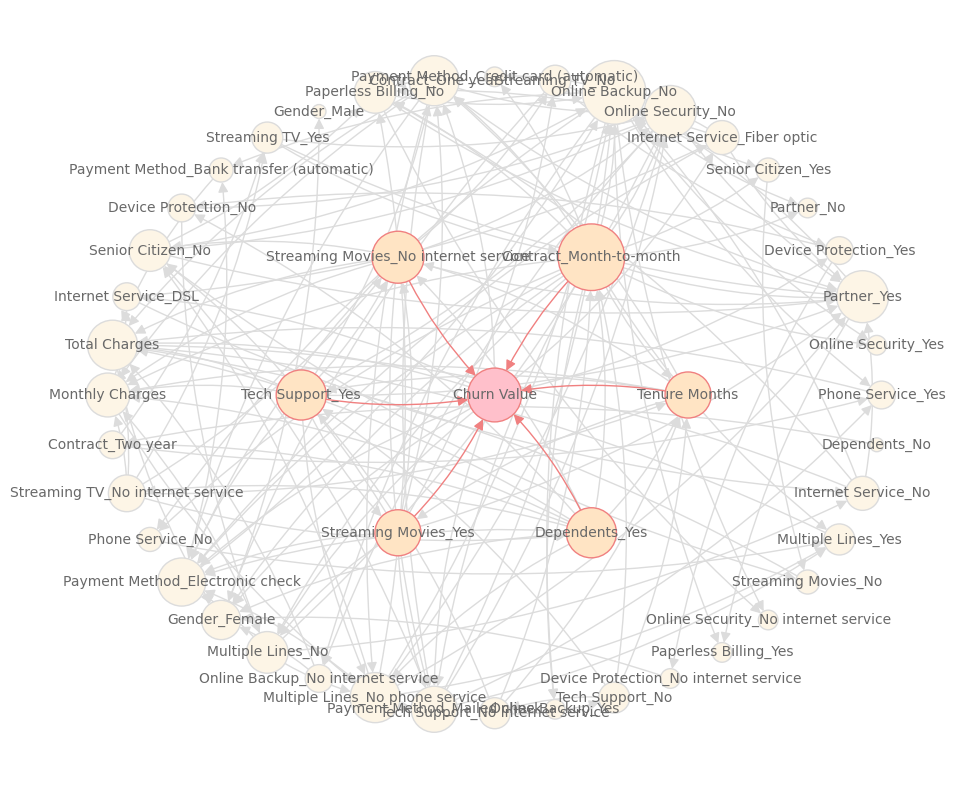

In [6]:
fig = plt.figure(figsize=(10, 8))
for i in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[i].set_visible(False)
    
# model_graph.remove_nodes_from(list(set(features) - (set(outcomes) | set(relevant_features))))

degrees = model_graph.degree()
node_colors = ['pink' if node in outcomes else 'bisque' if node in relevant_features else 'oldlace' for node in model_graph.nodes]
node_sizes = [max(v, 1) * 100 for k, v in degrees]
node_edge_colors = ['lightcoral' if node in relevant_nodes else 'gainsboro' for node in model_graph.nodes]
edge_colors = ['lightcoral' if edge in relevant_edges else 'gainsboro' for edge in model_graph.edges]
pos = nx.shell_layout(model_graph, [outcomes, relevant_features, list(set(features) - set(relevant_features))])

# draw the graph
nodes = nx.draw_networkx_nodes(model_graph,
                               pos=pos,
                               node_color=node_colors,
                               node_size=node_sizes,
                               edgecolors=node_edge_colors)

edges = nx.draw_networkx_edges(model_graph,
                               pos=pos,
                               connectionstyle="arc3,rad=0.1",
                               node_size=node_sizes,
                               edge_color=edge_colors,
                               arrowsize=15)

labels = nx.draw_networkx_labels(model_graph,
                                 pos,
                                 font_size=10,
                                 font_color='dimgray',
                                 clip_on=False)

# bring relevant edges to the top
edge_list = list(model_graph.edges)
edge_index = [edge_list.index(x) for x in relevant_edges]
for i, edge in enumerate(edges):
    if i in edge_index:
        edge.set_zorder(1)
    else:
        edge.set_zorder(0)

# plot the graph
plt.tight_layout()
plt.show()
# plt.savefig('graph.png', dpi=300)

# Evaluation

In [7]:
def evaluate(clf, x, y, row):
    y_pred = clf.predict(x)
    
    accuracy = accuracy_score(y, y_pred)
    bal_accuracy = balanced_accuracy_score(y, y_pred)
    precision_0 = precision_score(y, y_pred, pos_label=1)
    precision_1 = precision_score(y, y_pred, pos_label=0)
    recall_0 = recall_score(y, y_pred, pos_label=1)
    recall_1 = recall_score(y, y_pred, pos_label=0)
    f1_0 = f1_score(y, y_pred, pos_label=1)
    f1_1 = f1_score(y, y_pred, pos_label=0)
    
    metrics_df.loc[row] = [accuracy, bal_accuracy, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1]

In [8]:
def evaluateKNN(x_train, x_val, x_test, row):
    # hyperparameter tuning
    loss = []
    x_axis = np.linspace(5, 40, num=8, dtype=int)
    
    for i in x_axis:
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_val)
        loss.append(log_loss(y_val, y_pred))

    # plot
    fig = plt.figure(figsize=(5, 3))
    plt.xticks(x_axis)
    plt.plot(x_axis, loss)
    plt.show()
    
    # find optimal neighbors
    sorted_loss = np.argsort(loss)
    n_neighbors = x_axis[sorted_loss[0]]
    print(f'\nOptimal neighbors: {n_neighbors}\n')

    # test
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    evaluate(knn, x_test, y_test, row)

In [9]:
def evaluateLR(x_train, x_val, x_test, row):
    # hyperparameter tuning
    loss = []
    x_axis = np.logspace(-3, 0, num=10)
    
    for i in x_axis:
        lr = LogisticRegression(C=i, random_state=seed)
        lr.fit(x_train, y_train)
        y_pred = lr.predict(x_val)
        loss.append(log_loss(y_val, y_pred))

    # plot
    fig = plt.figure(figsize=(5, 3))
    plt.xticks(x_axis)
    plt.xscale('log') 
    plt.plot(x_axis, loss)
    plt.show()
    
    # find optimal C value
    sorted_loss = np.argsort(loss)
    C = x_axis[sorted_loss[0]]
    print(f'\nOptimal C: {C}\n')

    # test
    lr = LogisticRegression(C=C, random_state=seed)
    lr.fit(x_train, y_train)
    evaluate(lr, x_test, y_test, row)

In [10]:
def evaluateSVM(x_train, x_val, x_test, row):
    # hyperparameter tuning
    loss = []
    x_axis = np.logspace(-3, 0, num=10)
    
    for i in x_axis:
        svc = SVC(C=i, random_state=seed)
        svc.fit(x_train, y_train)
        y_pred = svc.predict(x_val)
        loss.append(log_loss(y_val, y_pred))

    # plot
    fig = plt.figure(figsize=(5, 3))
    plt.xticks(x_axis)
    plt.xscale('log') 
    plt.plot(x_axis, loss)
    plt.show()
    
    # find optimal C value
    sorted_loss = np.argsort(loss)
    C = x_axis[sorted_loss[0]]
    print(f'\nOptimal C: {C}\n')

    # test
    svc = SVC(C=C, random_state=seed)
    svc.fit(x_train, y_train)
    evaluate(svc, x_test, y_test, row)

In [11]:
metrics_df = pd.DataFrame(columns=['accuracy', 'bal_accuracy', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1'])

## All Features

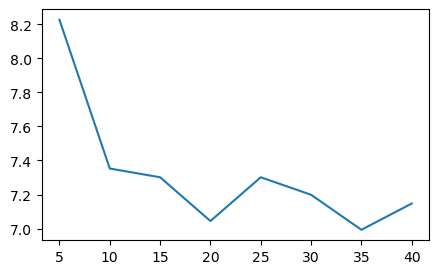


Optimal neighbors: 35



In [12]:
evaluateKNN(X_train, X_val, X_test, 'KNN - All')

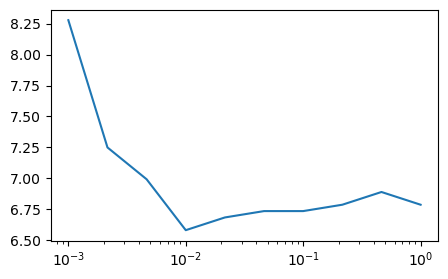


Optimal C: 0.01



In [13]:
evaluateLR(X_train, X_val, X_test, 'LR - All')

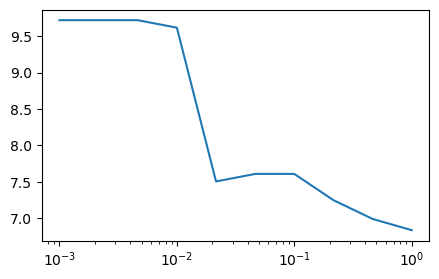


Optimal C: 1.0



In [14]:
evaluateSVM(X_train, X_val, X_test, 'SVM - All')

## Causality Based Features

In [15]:
X_train_causal = X_train[list(relevant_features)]
X_val_causal = X_val[list(relevant_features)]
X_test_causal = X_test[list(relevant_features)]

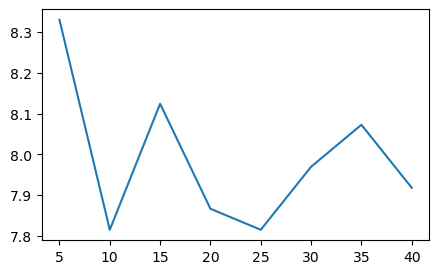


Optimal neighbors: 10



In [16]:
evaluateKNN(X_train_causal, X_val_causal, X_test_causal, 'KNN - Causal')

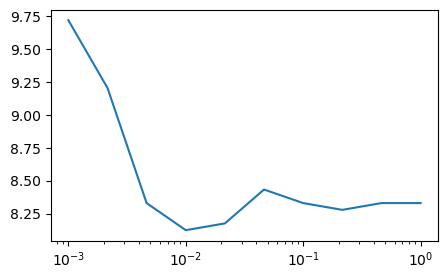


Optimal C: 0.01



In [17]:
evaluateLR(X_train_causal, X_val_causal, X_test_causal, 'LR - Causal')

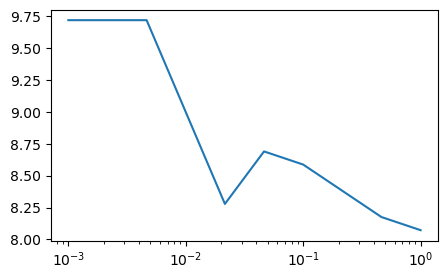


Optimal C: 1.0



In [18]:
evaluateSVM(X_train_causal, X_val_causal, X_test_causal, 'SVM - Causal')

## ANOVA

In [19]:
anova = SelectKBest(f_classif, k=n_features).fit(X_train, y_train)

anova_features = X_train.iloc[:, np.argsort(anova.scores_)[:6]].columns.values

for feature in sorted(anova_features):
    print(feature)

Gender_Female
Gender_Male
Multiple Lines_No
Multiple Lines_No phone service
Phone Service_No
Phone Service_Yes


In [20]:
X_train_anova = anova.transform(X_train)
X_val_anova = anova.transform(X_val)
X_test_anova = anova.transform(X_test)

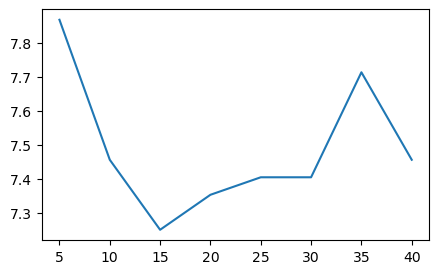


Optimal neighbors: 15



In [21]:
evaluateKNN(X_train_anova, X_val_anova, X_test_anova, 'KNN - ANOVA')

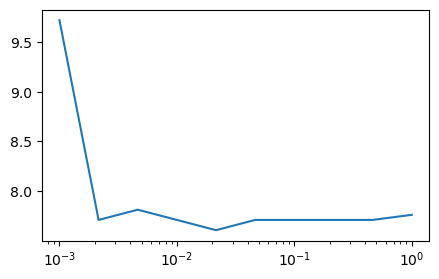


Optimal C: 0.021544346900318832



In [22]:
evaluateLR(X_train_anova, X_val_anova, X_test_anova, 'LR - ANOVA')

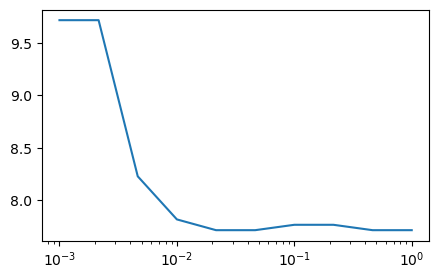


Optimal C: 0.021544346900318832



In [23]:
evaluateSVM(X_train_anova, X_val_anova, X_test_anova, 'SVM - ANOVA')

## Pearson

In [24]:
pearson = SelectKBest(r_regression, k=n_features).fit(X_train, y_train)

pearson_features = X_train.iloc[:, np.argsort(pearson.scores_)[:6]].columns.values

for feature in sorted(pearson_features):
    print(feature)

Contract_Two year
Dependents_Yes
Device Protection_No internet service
Online Backup_No internet service
Tech Support_No internet service
Tenure Months


In [25]:
X_train_pearson = pearson.transform(X_train)
X_val_pearson = pearson.transform(X_val)
X_test_pearson = pearson.transform(X_test)

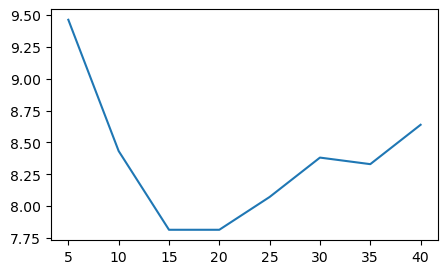


Optimal neighbors: 15



In [26]:
evaluateKNN(X_train_pearson, X_val_pearson, X_test_pearson, 'KNN - Pearson')

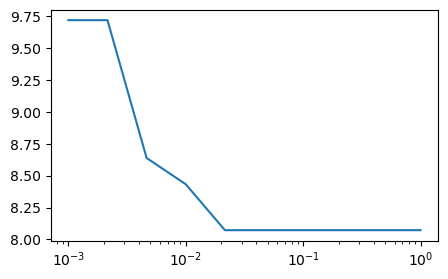


Optimal C: 0.021544346900318832



In [27]:
evaluateLR(X_train_pearson, X_val_pearson, X_test_pearson, 'LR - Pearson')

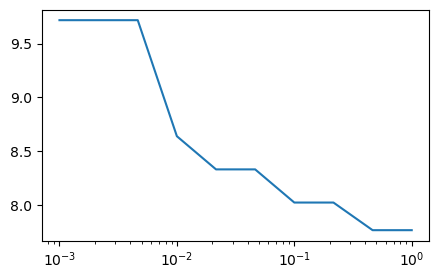


Optimal C: 0.46415888336127775



In [28]:
evaluateSVM(X_train_pearson, X_val_pearson, X_test_pearson, 'SVM - Pearson')

## PCA

In [29]:
pca = PCA(n_components=n_features).fit(X_train)

In [30]:
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

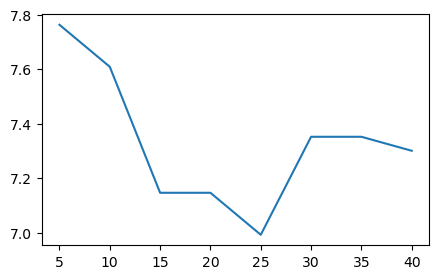


Optimal neighbors: 25



In [31]:
evaluateKNN(X_train_pca, X_val_pca, X_test_pca, 'KNN - PCA')

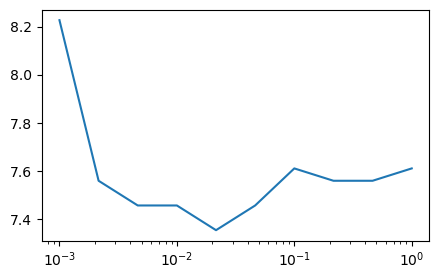


Optimal C: 0.021544346900318832



In [32]:
evaluateLR(X_train_pca, X_val_pca, X_test_pca, 'LR - PCA')

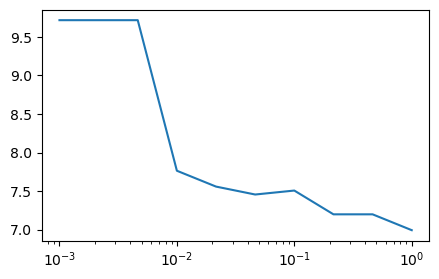


Optimal C: 1.0



In [33]:
evaluateSVM(X_train_pca, X_val_pca, X_test_pca, 'SVM - PCA')

## Random

In [34]:
r_cols = random.choices(range(X_train.shape[1]), k=n_features)

random_features = X_train.iloc[:, r_cols].columns.values

for feature in sorted(random_features):
    print(feature)

Contract_One year
Internet Service_No
Online Backup_No internet service
Online Security_No
Phone Service_No
Streaming Movies_No


In [35]:
X_train_random = X_train.loc[:, random_features]
X_val_random = X_val.loc[:, random_features]
X_test_random = X_test.loc[:, random_features]

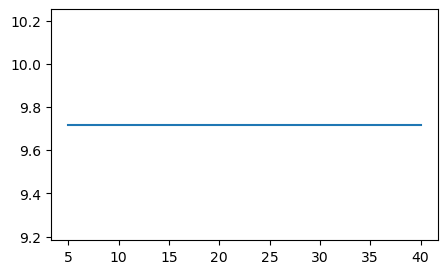


Optimal neighbors: 5



In [36]:
evaluateKNN(X_train_random, X_val_random, X_test_random, 'KNN - Random')

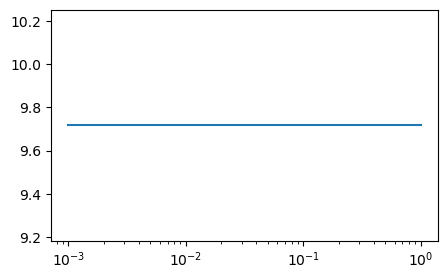


Optimal C: 0.001



In [37]:
evaluateLR(X_train_random, X_val_random, X_test_random, 'LR - Random')

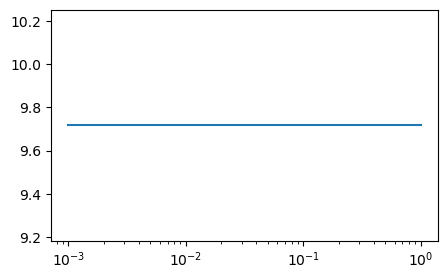


Optimal C: 0.001



In [38]:
evaluateSVM(X_train_random, X_val_random, X_test_random, 'SVM - Random')

# Metrics

In [39]:
def sorter(x):
    order = ['All', 'Random', 'ANOVA', 'Pearson', 'PCA', 'Causal']
    return [f'{xi.split()[0]}_{order.index(xi.split()[2])}' for xi in x]

metrics_df.sort_index(key=sorter, inplace=True)

metrics_df

,accuracy,bal_accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1
KNN - All,0.806268,0.756387,0.584211,0.888672,0.660714,0.852060,0.620112,0.869981
KNN - Random,0.760684,0.500000,0.000000,0.760684,0.000000,1.000000,0.000000,0.864078
KNN - ANOVA,0.793447,0.686764,0.582734,0.845471,0.482143,0.891386,0.527687,0.867821
KNN - Pearson,0.796296,0.715155,0.576687,0.862709,0.559524,0.870787,0.567976,0.866729
KNN - PCA,0.807692,0.716526,0.610738,0.860759,0.541667,0.891386,0.574132,0.875805
KNN - Causal,0.809117,0.705223,0.625000,0.853357,0.505952,0.904494,0.559211,0.878182
LR - All,0.817664,0.723081,0.640845,0.862500,0.541667,0.904494,0.587097,0.882998
LR - Random,0.760684,0.500000,0.000000,0.760684,0.000000,1.000000,0.000000,0.864078
LR - ANOVA,0.799145,0.680310,0.608000,0.840555,0.452381,0.908240,0.518771,0.873087
LR - Pearson,0.796296,0.696796,0.586207,0.850987,0.505952,0.887640,0.543131,0.868928


In [40]:
print(metrics_df.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  accuracy &  bal\_accuracy &  precision\_0 &  precision\_1 &  recall\_0 &  recall\_1 &      f1\_0 &      f1\_1 \\
\midrule
KNN - All     &  0.806268 &      0.756387 &     0.584211 &     0.888672 &  0.660714 &  0.852060 &  0.620112 &  0.869981 \\
KNN - Random  &  0.760684 &      0.500000 &     0.000000 &     0.760684 &  0.000000 &  1.000000 &  0.000000 &  0.864078 \\
KNN - ANOVA   &  0.793447 &      0.686764 &     0.582734 &     0.845471 &  0.482143 &  0.891386 &  0.527687 &  0.867821 \\
KNN - Pearson &  0.796296 &      0.715155 &     0.576687 &     0.862709 &  0.559524 &  0.870787 &  0.567976 &  0.866729 \\
KNN - PCA     &  0.807692 &      0.716526 &     0.610738 &     0.860759 &  0.541667 &  0.891386 &  0.574132 &  0.875805 \\
KNN - Causal  &  0.809117 &      0.705223 &     0.625000 &     0.853357 &  0.505952 &  0.904494 &  0.559211 &  0.878182 \\
LR - All      &  0.817664 &      0.723081 &     0.640845 &     0.862500 &  0.541667 &  0.904494 & 